# Where to open a new coffee shop?

![](https://raw.githubusercontent.com/rafaeldjsm/Data_Science/master/Imagens/webp-net-resizeimage-6-1.webp)

## 📖 Background
You are helping a client who owns coffee shops in Colorado. The company's coffee shops serve high-quality and responsibly sourced coffee,  pastries, and sandwiches. They operate three locations in Fort Collins and want to expand into Denver. 

Your client believes that the ideal location for a new store is close to affluent households, and the store appeals to the 20-35 year old demographic.
 
Your team collected geographical and demographic information about Denver's neighborhoods to assist the search. They also collected data for Starbucks stores in Denver. Starbucks and the new coffee shops do not compete for the same clients; the team included their location as a reference.

## 💾 The data
You have assembled information from three different sources ([locations](https://github.com/chrismeller/), [neighborhoods](http://data.denvergov.org), [demographics](https://www.census.gov/)):

#### Starbucks locations in Denver, Colorado
- "StoreNumber" - Store Number as assigned by Starbucks
- "Name" - Name identifier for the store
- "PhoneNumber" - Phone number for the store
- "Street 1, 2, and 3" - Address for the store
- "PostalCode" - Zip code of the store
- "Longitude, Latitude" - Coordinates of the store

#### Neighborhoods' geographical information
- "NBHD_ID" - Neighborhood ID (matches the census information)
- "NBHD_NAME" - Name of the statistical neighborhood
- "Geometry" - Polygon that defines the neighborhood

#### Demographic information
- "NBHD_ID" - Neighborhood ID (matches the geographical information)
- "NBHD_NAME' - Nieghborhood name
- "POPULATION_2010' - Population in 2010
- "AGE_ " - Number of people in each age bracket (< 18, 18-34, 35-65, and > 65)
- "NUM_HOUSEHOLDS" - Number of households in the neighborhood
- "FAMILIES" - Number of families in the neighborhood
- "NUM_HHLD_100K+" - Number of households with income above 100 thousand USD per year

_Starbucks locations were scrapped from the Starbucks store locator webpage by [Chris Meller](https://github.com/chrismeller/)._  
_Statistical Neighborhood information from the [City of Denver Open Data Catalog](http://data.denvergov.org), [CC BY 3.0](http://creativecommons.org/licenses/by/3.0/) license._      
_Census information from the [United States Census Bureau](https://www.census.gov/). Publicly available information._

# 1 - Imports

In [161]:
%%capture
!pip install geopandas

In [162]:
import pandas as pd
import numpy as np
import geopandas as gpd # '0.11.1'
import matplotlib.pyplot as plt
import seaborn as sns
denver = pd.read_csv('./data/denver.csv')
denver.head()

,StoreNumber,Name,PhoneNumber,Street1,Street2,Street3,PostalCode,Longitude,Latitude
0,27708-240564,Auraria Tivoli - Student Union,3035563700,900 Auraria Parkway,NaN,NaN,80204,-105.01,39.75
1,75828-94910,Grand Hyatt Denver,303-295-1234,1740 Welton St,NaN,NaN,802023940,-104.99,39.75
2,74105-23807,Safeway - Denver #1463,303-722-6117,2150 S Downing,NaN,NaN,802104528,-104.97,39.68
3,22871-102491,Safeway - Denver #1248,303-477-5091,2660 Federal Blvd,NaN,NaN,80211,-105.02,39.76
4,11105-100844,Highlands Garden Village,303-455-3382,4500 W 38th Ave,NaN,NaN,802122001,-105.05,39.77


In [163]:
# Create a geodataframe from denver

# Transforming the Denver dataframe into a GeoDataframe by combining the coordinates
gdf = gpd.GeoDataFrame(denver, geometry = gpd.points_from_xy(denver.Longitude, denver.Latitude),crs = 4326)

neighborhoods = gpd.read_file('./data/neighborhoods.shp',crs = 4326) 
#geopandas.geodataframe.GeoDataFrame
neighborhoods = neighborhoods.set_crs(epsg = 4326,allow_override=True)

neighborhoods.head()

,NBHD_ID,NBHD_NAME,geometry
0,2,Auraria,"POLYGON ((-105.00042 39.74552, -105.00041 39.7..."
1,21,Cory - Merrill,"POLYGON ((-104.94070 39.69540, -104.94070 39.6..."
2,7,Belcaro,"POLYGON ((-104.94070 39.71156, -104.94069 39.7..."
3,70,Washington Park,"POLYGON ((-104.95931 39.71566, -104.95931 39.7..."
4,71,Washington Park West,"POLYGON ((-104.97342 39.68982, -104.97356 39.6..."


# 2 Exploratory Data Analysis

## 2.1 Merge Starbucks locations in Denver and neighborhoods geodataframe

In [164]:
gdf['Neighborhoods'] = np.nan

#`rtree` or `pygeos` dont work for sjoin
# loop for merge the geodataframes
for nk,k in enumerate(gdf.geometry):
    for nj,j in enumerate(neighborhoods.geometry):
        if j.contains(k): # k.intersects(j)
        	gdf.iloc[nk,-1] = neighborhoods.iloc[nj,1]
            
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 78 entries, 0 to 77
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   StoreNumber    78 non-null     object  
 1   Name           78 non-null     object  
 2   PhoneNumber    77 non-null     object  
 3   Street1        78 non-null     object  
 4   Street2        15 non-null     object  
 5   Street3        11 non-null     object  
 6   PostalCode     78 non-null     int64   
 7   Longitude      78 non-null     float64 
 8   Latitude       78 non-null     float64 
 9   geometry       78 non-null     geometry
 10  Neighborhoods  74 non-null     object  
dtypes: float64(2), geometry(1), int64(1), object(7)
memory usage: 6.8+ KB


### 2.1.1 Checking for missing values

In [165]:
gdf[gdf.Neighborhoods.isna()]

,StoreNumber,Name,PhoneNumber,Street1,Street2,Street3,PostalCode,Longitude,Latitude,geometry,Neighborhoods
6,19695-165566,"Hampden & Santa Fe, Sheridan",3037611675,3500 A River Point Parkway,NaN,NaN,80110,-105.01,39.65,POINT (-105.01000 39.65000),NaN
36,27847-248910,Chambers and 40th,7205820998,4005 Chambers Road,NaN,NaN,80239,-104.81,39.77,POINT (-104.81000 39.77000),NaN
57,8863-95109,102nd & Grant-Thornton,303-255-3069,"10005 Grant St, Unit F",NaN,NaN,802292033,-104.98,39.88,POINT (-104.98000 39.88000),NaN
59,6540-62379,Monaco & Evans,303-504-4600,2223 S. Monaco Parkway,G110,Villa Monaco,802225893,-104.91,39.68,POINT (-104.91000 39.68000),NaN


**On a visual check, it is noted that:**

- $\textcolor{red}{\text{3500 A River Point Parkway is out of Denver;}}$ 
- 4005 Chambers Road is in Montbello/Denver.
- $\textcolor{red}{\text{10005 Grant St, Unit F is out of Denver, is in Thornton;}}$ 
- 2223 S. Monaco Parkway is in Goldsmith/Denver;

> *Checking the coordinates of the dataframe denver on google maps, it is observed that the coordinates are correct, maybe there is a difference between the georeferencing systems in relation to the dataframe neighborhoods.*


## 2.2 Data Visualization

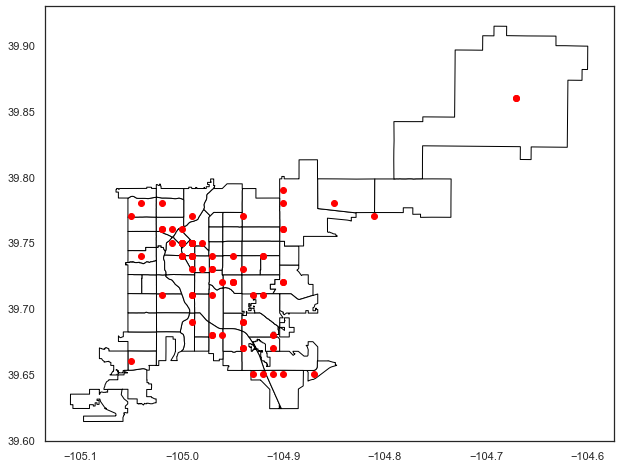

In [166]:
# Manual correction of values
gdf.loc[36,'Neighborhoods'] = 'Montbello'
gdf.loc[59,'Neighborhoods'] = 'Goldsmith'

gdf.dropna(subset='Neighborhoods', inplace = True)

ax = neighborhoods.plot(color='white', edgecolor='black', figsize=(15,8))
gdf.plot(ax=ax, color = 'red');

### 2.2.1 Visualization and indicating the starbucks density ratio by neighborhood area.

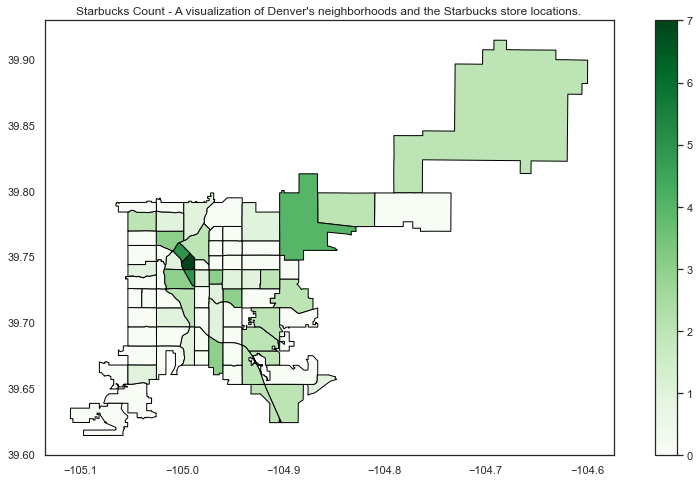

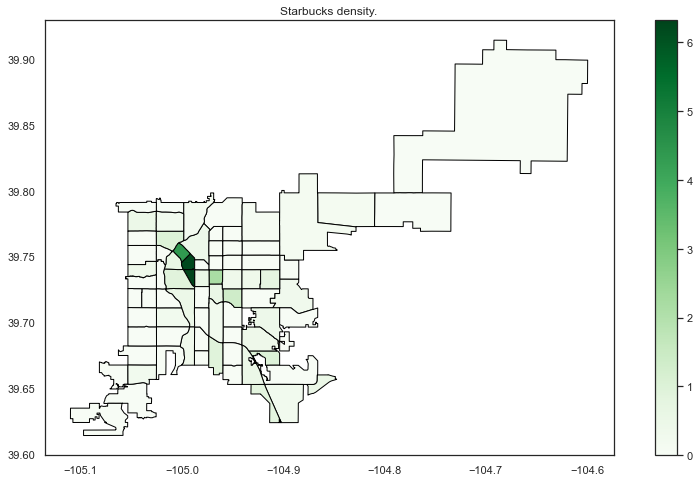

In [167]:
# use GeoSeries.to_crs() to project geometries to a planar CRS before using area method. (UTM EPSG:32714 WGS 84 / UTM zone 14S)
tost = neighborhoods.geometry.copy()
tost= tost.to_crs(epsg=32714)

# AREA (km2)
neighborhoods['AREA'] = tost.area/(10**6)

# Groupby Neighborhoods
count_Neigh = gdf.Neighborhoods.value_counts().to_frame()
count_Neigh.columns = ['Count_Starbucks']

# Merging the neighborhood dataframe with the starbucks store count dataframe. 
neighborhoods2 = neighborhoods.merge(count_Neigh, left_on = 'NBHD_NAME', how = 'left', right_index = True)
neighborhoods2.fillna(0,inplace = True)
neighborhoods2['Starbucks_density'] = neighborhoods2['Count_Starbucks']/neighborhoods2['AREA']
neighborhoods2.sort_values(by = 'NBHD_ID',inplace = True)


# Plots
neighborhoods2.plot(column='Count_Starbucks', 
                    edgecolor='black', 
                    figsize=(15,8), 
                    legend = True,
                    cmap = "Greens");
plt.title(label = "Starbucks Count - A visualization of Denver's neighborhoods and the Starbucks store locations.");

neighborhoods2.plot(column='Starbucks_density', 
                    edgecolor='black', 
                    figsize=(15,8), 
                    legend = True,
                    cmap = "Greens");
plt.title(label = "Starbucks density.");

### 2.2.2 Kernel density estimation of Starbucks stores distribution.

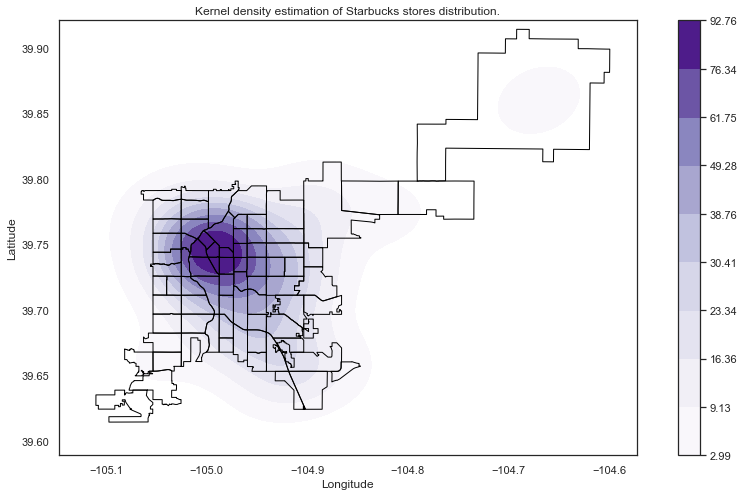

In [168]:
sns.set(rc={'figure.figsize':(15,8)})
sns.set_style("white")
ax = sns.kdeplot(gdf['Longitude'], gdf['Latitude'],shade = True, cmap='Purples',kind = 'kde',cbar=True)
plt.title(label = "Kernel density estimation of Starbucks stores distribution.")

neighborhoods2.plot(edgecolor='black',color = 'None', ax = ax)
plt.show()

In [169]:
census = pd.read_csv('./data/census.csv')
census.fillna(0, inplace = True)
census.head()

,NBHD_ID,NBHD_NAME,POPULATION_2010,AGE_LESS_18,AGE_18_TO_34,AGE_35_TO_65,AGE_65_PLUS,NUM_HOUSEHOLDS,FAMILIES,NUM_HHLD_100K+
0,1,Athmar Park,8898.0,2649.0,2406.0,3112.0,731.0,2781.0,1964.0,425.0
1,2,Auraria,705.0,7.0,635.0,57.0,6.0,60.0,15.0,0.0
2,3,Baker,4879.0,745.0,1762.0,2037.0,335.0,2447.0,833.0,0.0
3,4,Barnum,6111.0,2015.0,1647.0,2089.0,360.0,1782.0,1289.0,120.0
4,5,Barnum West,5376.0,1579.0,1380.0,1824.0,593.0,1704.0,1207.0,0.0


### 2.2.3 Visualization and indicating of people in the target demographic

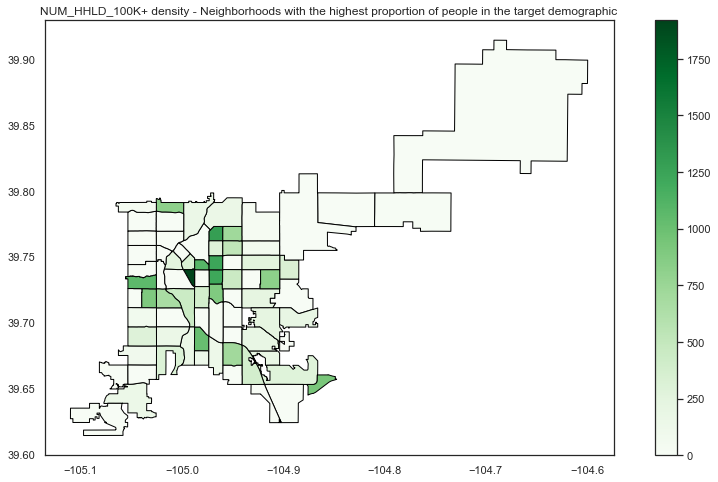

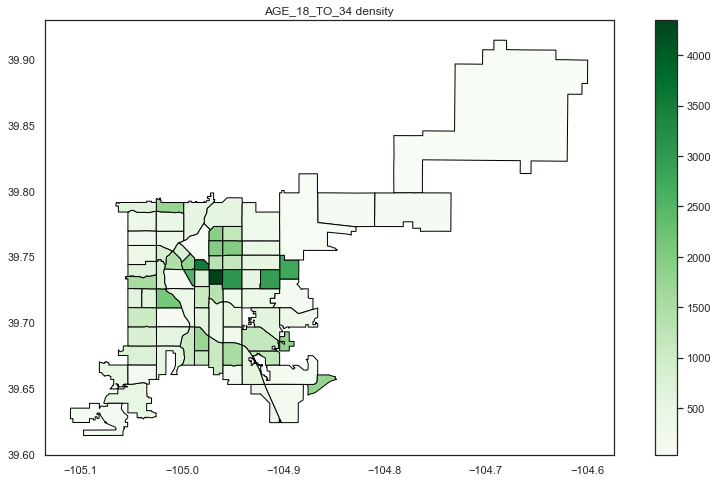

In [170]:
# Merging the dataframe of neighborhoods with those of the census.
neighborhoods2 = neighborhoods2.join(census[['AGE_18_TO_34','NUM_HHLD_100K+']])

# Creating the density columns
neighborhoods2['AGE_18_TO_34_density'] = neighborhoods2['AGE_18_TO_34']/neighborhoods2['AREA']
neighborhoods2['NUM_HHLD_100K+_density'] = neighborhoods2['NUM_HHLD_100K+']/neighborhoods2['AREA']

# Plots
neighborhoods2.plot(column='NUM_HHLD_100K+_density', edgecolor='black', figsize=(15,8), legend = True,cmap = "Greens")
plt.title(label = 'NUM_HHLD_100K+ density - Neighborhoods with the highest proportion of people in the target demographic');

neighborhoods2.plot(column='AGE_18_TO_34_density', edgecolor='black', figsize=(15,8), legend = True,cmap = "Greens")
plt.title(label = 'AGE_18_TO_34 density');

### 2.2.4 Kernel density estimation of people in the target demographic

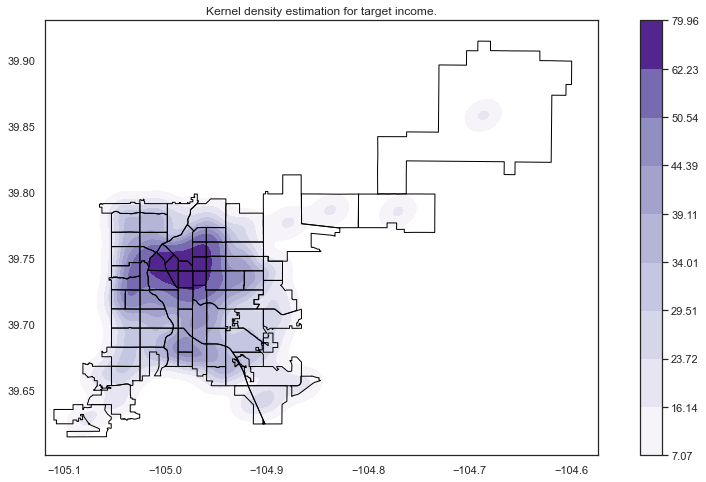

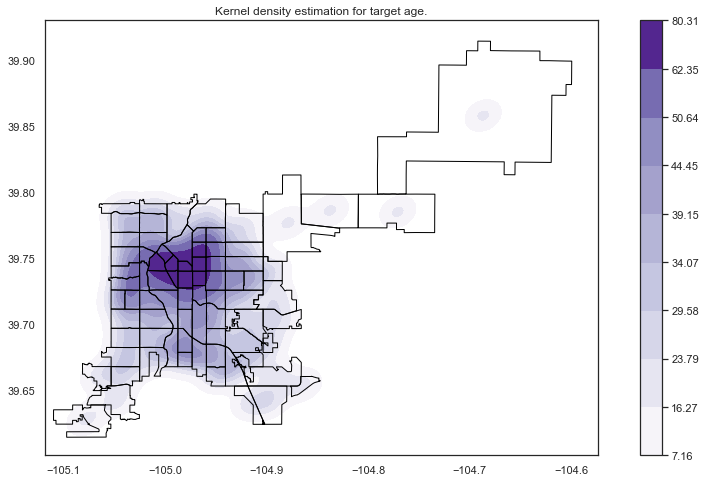

In [171]:
# For the kernel density we will generate the number of points proportional to the quantities.

lst_incx = []
lst_incy = []
for k in neighborhoods2.geometry.centroid:
    for j in (neighborhoods2['NUM_HHLD_100K+']/(neighborhoods2['NUM_HHLD_100K+'].max())):
        for w in range(int(10*j)):
            lst_incx.append(k.x)
            lst_incy.append(k.y)

ax = sns.kdeplot(lst_incx,lst_incy,shade = True, cmap='Purples',cbar=True)
plt.title(label = "Kernel density estimation for target income.")
neighborhoods2.plot(edgecolor='black',color = 'None', ax = ax)
plt.show()


lst_agex = []
lst_agey = []
for k in neighborhoods2.geometry.centroid:
    for j in (neighborhoods2['AGE_18_TO_34']/(neighborhoods2['AGE_18_TO_34'].max())):
        for w in range(int(10*j)):
            lst_agex.append(k.x)
            lst_agey.append(k.y)

ax = sns.kdeplot(lst_agex,lst_agey,shade = True, cmap='Purples',cbar=True)
plt.title(label = "Kernel density estimation for target age.")
neighborhoods2.plot(edgecolor='black',color = 'None', ax = ax)
plt.show()

In [172]:
# Checking the 9 best results for each criterion.

df100k = neighborhoods2.sort_values(by = 'NUM_HHLD_100K+_density', ascending = False).head(9)

df_AGE_18_TO_34 = neighborhoods2.sort_values(by = 'AGE_18_TO_34_density', ascending = False).head(9)

df_Count_Starbucks = neighborhoods2.sort_values(by = 'Starbucks_density', ascending = False).head(9)
df_Count_Starbucks

,NBHD_ID,NBHD_NAME,geometry,AREA,Count_Starbucks,Starbucks_density,AGE_18_TO_34,NUM_HHLD_100K+,AGE_18_TO_34_density,NUM_HHLD_100K+_density
47,16,Civic Center,"POLYGON ((-104.98739 39.74011, -104.98739 39.7...",0.791594,5.0,6.316370,2012.0,1519.0,2541.707311,1918.913223
48,10,CBD,"POLYGON ((-104.98740 39.74736, -104.98740 39.7...",1.122893,7.0,6.233898,1995.0,385.0,1776.660793,342.864364
49,63,Union Station,"POLYGON ((-104.99169 39.75229, -104.99293 39.7...",1.142781,5.0,4.375291,874.0,0.0,764.800904,0.000000
25,12,Cheesman Park,"POLYGON ((-104.96019 39.72911, -104.96077 39.7...",1.371804,3.0,2.186902,5961.0,1680.0,4345.373953,1224.665029
6,13,Cherry Creek,"POLYGON ((-104.94070 39.71156, -104.94091 39.7...",2.179473,3.0,1.376480,621.0,0.0,284.931275,0.000000
20,36,Highland,"POLYGON ((-104.99820 39.76930, -104.99821 39.7...",3.003097,3.0,0.998969,906.0,0.0,301.688513,0.000000
40,30,Goldsmith,"POLYGON ((-104.90564 39.67844, -104.90550 39.6...",2.014402,2.0,0.992850,2457.0,364.0,1219.716637,180.698761
23,64,University,"POLYGON ((-104.95945 39.68473, -104.95945 39.6...",3.246451,3.0,0.924086,3397.0,442.0,1046.373436,136.148678
72,41,Lincoln Park,"POLYGON ((-104.99857 39.74019, -104.99841 39.7...",3.324120,3.0,0.902494,370.0,0.0,111.307643,0.000000


# 3 Final Considerations

## First, let's check the neighborhoods in common among the top nine in each income and age criteria.

> Note that there are only three out of the 9 best neighborhoods in common when considering the two main criteria, in these neighborhoods 2 have a good density of starbusks stores and only one with a low density, as the amount of starbucks is given only as a reference, we will adopt the three neighborhoods found above.

- Civic Center
- Cheesman Park
- North Capitol Hill

>> This strategy also focuses on downtown Denver, as seen in the Starbucks Store Distribution Kernel Density Estimate and Income and Age Kernel Density Estimate.

,NBHD_ID,NBHD_NAME,geometry,AREA,Count_Starbucks,Starbucks_density,AGE_18_TO_34,NUM_HHLD_100K+,AGE_18_TO_34_density,NUM_HHLD_100K+_density
0,16,Civic Center,"POLYGON ((-104.98739 39.74011, -104.98739 39.7...",0.791594,5.0,6.316370,2012.0,1519.0,2541.707311,1918.913223
1,12,Cheesman Park,"POLYGON ((-104.96019 39.72911, -104.96077 39.7...",1.371804,3.0,2.186902,5961.0,1680.0,4345.373953,1224.665029
2,47,North Capitol Hill,"POLYGON ((-104.97338 39.74378, -104.97339 39.7...",0.918346,0.0,0.000000,3238.0,1010.0,3525.905913,1099.803883


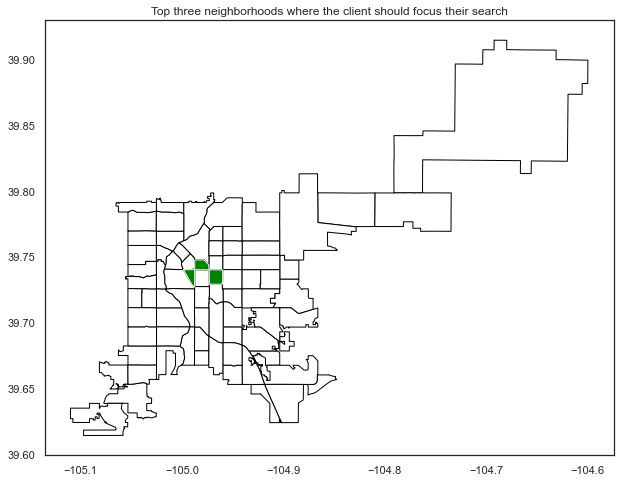

In [173]:
# Merging to intersection of criteria.
dftop3 = df100k.merge(df_AGE_18_TO_34, how = 'inner')
display(dftop3)

ax = neighborhoods2.plot(color='white',edgecolor='black', figsize=(15,8))
dftop3.plot(ax=ax, color = 'Green')
plt.title(label = 'Top three neighborhoods where the client should focus their search');

## 💪 Challenge
Provide your client a list of neighborhoods in Denver where they should consider expanding. Include:
* A visualization of Denver's neighborhoods and the Starbucks store locations.
* Find the neighborhoods with the highest proportion of people in the target demographic.
* Select the top three neighborhoods where your client should focus their search.

## ✅ Checklist before publishing
- Rename your workspace to make it descriptive of your work. N.B. you should leave the notebook name as notebook.ipynb.
- **Remove redundant cells** like the judging criteria, so the workbook is focused on your work.
- Check that all the cells run without error.